#EDA

In [132]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
os.getcwd()

pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')


In [36]:
#load data
df_age_gender = pd.read_csv('../data/raw/age_gender_bkts.csv')
df_countries = pd.read_csv('../data/raw/countries.csv')
df_sessions = pd.read_csv('../data/raw/sessions.csv')
df_train = pd.read_csv('../data/raw/train_users_2.csv')
df_test = pd.read_csv('../data/raw/test_users.csv')

In [44]:
df_all = pd.concat((df_train,df_test),axis= 0 ,ignore_index= True)

In [50]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [52]:
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

date_first_booking has 186639 null values

age has 116866 null values

first_affiliate_tracked has 6085 null values

country_destination has 62096 null values



In [62]:
#刪除date_first_booking，country_destination 欄位因為他們在test資料中都沒有
df_all = df_all.drop(['date_first_booking','country_destination'],axis= 1)


In [64]:
# age 和 first_affiliate_tracked 需處理缺失值
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(f'{i} has {ab} null values\n')

age has 116866 null values

first_affiliate_tracked has 6085 null values



In [65]:
df_all.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [91]:
df_train.gender.value_counts()

gender
-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: count, dtype: int64

In [87]:
columns = df_all.columns.tolist()
columns = [col for col in columns if col not in ['id', 'date_account_created', 'timestamp_first_active']]

for i in columns:
    print(df_all[i].value_counts())


gender
-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: count, dtype: int64
age
30.0      7712
28.0      7687
29.0      7647
31.0      7540
27.0      7462
          ... 
1953.0       1
132.0        1
150.0        1
112.0        1
1941.0       1
Name: count, Length: 145, dtype: int64
signup_method
basic       198222
facebook     74864
google        2438
weibo           23
Name: count, dtype: int64
signup_flow
0     206092
25     29834
12     11244
3       8822
2       6881
23      6408
24      4328
1       1047
8        315
6        301
21       197
5         36
20        14
16        11
15        10
14         4
10         2
4          1
Name: count, dtype: int64
language
en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
pl               75
da

In [92]:
#轉換成類別變數
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_all[categorical_feature] = df_all[categorical_feature].astype('category')


### data need processing
1. miss value
    - age
    - first_affiliate_tracked

2. age 有 outliner, K-means 偵測

3. language 只有test資料有一筆 unknown 


In [109]:
age_mode = df_all.age.mode()[0]
df_all['age'].fillna(age_mode,inplace=True)

In [112]:
# age 異常檢測

#標準化
scalar = StandardScaler()
df_all['age_scaled'] = scalar.fit_transform(df_all[['age']])


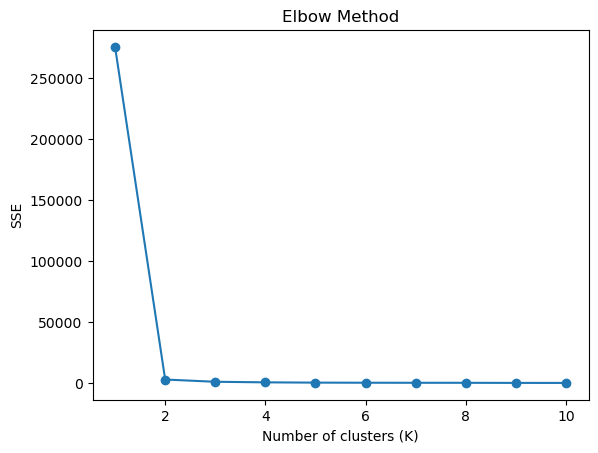

In [115]:
#elbow method 找分群數
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_all[['age_scaled']])
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [133]:
# 分成 2 群
kmeans = KMeans(n_clusters=2, random_state=42)
df_all['age_cluster'] = kmeans.fit_predict(df_all[['age_scaled']])


In [135]:
#異常年齡處理為眾數
centroids = kmeans.cluster_centers_
df_all['distance_to_centroid'] = np.linalg.norm(df_all[['age_scaled']].values - centroids[df_all['age_cluster']], axis=1)
threshold = np.percentile(df_all['distance_to_centroid'], 99)
df_all.loc[df_all['distance_to_centroid'] > threshold, 'age'] = 30

# Visualize